In [2]:
import folium
import warnings
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from folium.features import GeoJsonTooltip

warnings.filterwarnings('ignore')

df = pd.read_csv("../data/curated/income_forecasted.csv")
population = pd.read_csv('../data/curated/final_population.csv')

In [3]:
# Remove suburbs where the counts for income are 0 for all years (nobody lives there)

empty_suburbs = ['industrial', 'lake king', 'migratory', 'moorabbin airport',
    'no usual address', 'offshore', 'royal botanic gardens victoria',
    'shipping', 'wilsons promontory']

df = df[~df['suburb'].isin(empty_suburbs)]

# Only filter out columns we want
df = df[['year', 'suburb', 'hi_4000_more_tot']]

# Merge with population data
combined_df = pd.merge(df, population, left_on=['year', 'suburb'], right_on=['year', 'sa2_name'])
combined_df = combined_df.drop('sa2_name', axis = 1)

# Take the proportion of people earning more than 4000 a week per suburb in 2021
combined_df['proportion']= combined_df['hi_4000_more_tot'] / combined_df['erp']
combined_2021 = combined_df[combined_df['year'] == 2021]

# Sort by descending order
combined_2021 = combined_2021.sort_values(by='proportion', ascending=False)

top_10_richest = combined_2021.head(10)

## Bar Plot

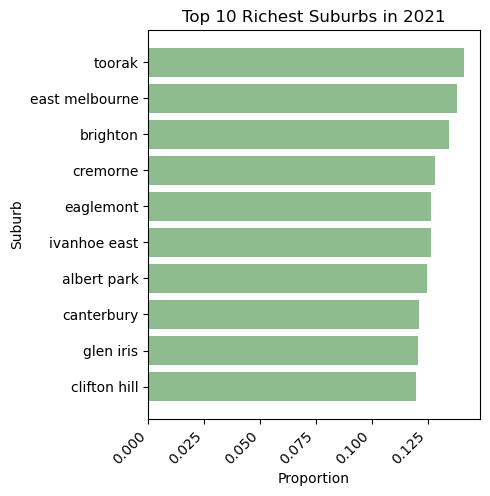

In [5]:
plt.figure(figsize=(5, 5))

plt.barh(top_10_richest['suburb'], top_10_richest['proportion'], color = 'darkseagreen')

# Add titles and labels
plt.title('Top 10 Richest Suburbs in 2021')
plt.xlabel('Proportion')
plt.ylabel('Suburb')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Invert the y-axis so the highest population is at the top
plt.gca().invert_yaxis()

# Display the bar chart
plt.tight_layout()
plt.savefig("../plots/2021_richest_suburbs.png")
plt.show()

## Maps

In [44]:
vic_suburbs_gdf = gpd.read_file('../data/map/Vic_Localities/gda2020_vicgrid/esrishape/whole_of_dataset/victoria/VMADMIN/LOCALITY_POLYGON.shp')
vic_suburbs_gdf = vic_suburbs_gdf.to_crs(epsg=4326)
vic_suburbs_gdf['suburb'] = vic_suburbs_gdf['GAZLOC'].str.lower()

merged = vic_suburbs_gdf.merge(combined_2021, on='suburb')

merged = merged.drop(columns=['PFI_CR', 'UFI_OLD', 'UFI_CR'], errors='ignore')

In [63]:
m = folium.Map(location=[-37.8136, 144.9631], zoom_start=10, tiles="cartodb positron")

# Add the choropleth map for population with a better color scheme and highlight on hover
choropleth = folium.Choropleth(
    geo_data=merged.__geo_interface__,    # Geopandas dataframe in GeoJSON format
    data=merged,                          # Dataframe with population data
    columns=['suburb', 'proportion'],     # Column to map (suburb names and population)
    key_on='feature.properties.suburb',        # Suburb name from GeoDataFrame (check this name)
    fill_color='RdYlGn',                       # Adjusted color scheme for better visual contrast
    fill_opacity=0.7,                          # Transparency of the color
    line_opacity=0.2,                          # Transparency of the borders
    highlight=True,                            # Enable highlighting when hovered
    legend_name=f'Proportion of Households Earning > $4000/Week' # Legend for the map
).add_to(m)

# Add tooltips to display suburb and population on hover
tooltip = GeoJsonTooltip(
    fields=['suburb', 'proportion'],
    aliases=['Suburb:', 'Proportion:'],
    localize=True,
    sticky=False,
    labels=True,
    style="""
        background-color: #F0EFEF;
        border: 1px solid black;
        border-radius: 3px;
        box-shadow: 3px;
    """
)

# Apply the tooltip to the GeoJson layer
folium.GeoJson(
    merged.__geo_interface__,
    style_function=lambda feature: {
        'fillColor': 'transparent',
        'color': 'transparent',
        'weight': 0
    },
    tooltip=tooltip
).add_to(m)

# Add interactive elements like LayerControl
folium.LayerControl().add_to(m)

m.save('../plots/richest_suburbs.html')

#m